# Jet Compression using an Autoencoder

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file('../my_matplotlib_rcparams')

## Loading and preparing the data

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [3]:
# Load data
train = pd.read_pickle('processed_data/train.pkl')
test = pd.read_pickle('processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [5]:
bs = 512  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

In [6]:
class AE_big_2D_v1(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v1, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 2)
        self.de1 = nn.Linear(2, 4)
        self.de2 = nn.Linear(4, 6)
        self.de3 = nn.Linear(6, 8)
        self.de4 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    

class AE_big_2D_v2(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v2, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 3)
        self.en5 = nn.Linear(3, 2)
        self.de1 = nn.Linear(2, 3)
        self.de2 = nn.Linear(3, 4)
        self.de3 = nn.Linear(4, 6)
        self.de4 = nn.Linear(6, 8)
        self.de5 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en5(self.tanh(self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))))

    def decode(self, x):
        return self.de5(self.tanh(self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [7]:
n_features = len(train.loc[0])
model = AE_big_2D_v2(n_features=n_features)

In [8]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
epochs_list = [10, 10, 10, 10, 10]
lrs = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-02
Epoch 0: Validation loss = 0.10377199133856628
Epoch 1: Validation loss = 0.08141602939504687
Epoch 2: Validation loss = 0.0787665836135324
Epoch 3: Validation loss = 0.07533079230344865
Epoch 4: Validation loss = 0.07425499515052607
Epoch 5: Validation loss = 0.07117981035033734
Epoch 6: Validation loss = 0.06976496606447287
Epoch 7: Validation loss = 0.06895824292734555
Epoch 8: Validation loss = 0.07093079642863634
Epoch 9: Validation loss = 0.053695841489892364
Setting learning rate to 3.0e-03
Epoch 0: Validation loss = 0.05191062892661825
Epoch 1: Validation loss = 0.051335414952325666
Epoch 2: Validation loss = 0.05042355128258932
Epoch 3: Validation loss = 0.04918087339844096
Epoch 4: Validation loss = 0.04862268003675922
Epoch 5: Validation loss = 0.0483277705381006
Epoch 6: Validation loss = 0.04817933969311518
Epoch 7: Validation loss = 0.04843099128988725
Epoch 8: Validation loss = 0.04776503723538074
Epoch 9: Validation loss = 0.047331617705

In [15]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
# save_path = './models/AE_2D_v2_bs512_loss00448.pt'
# torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [10]:
model.eval()

AE_big_2D_v2(
  (en1): Linear(in_features=4, out_features=8, bias=True)
  (en2): Linear(in_features=8, out_features=6, bias=True)
  (en3): Linear(in_features=6, out_features=4, bias=True)
  (en4): Linear(in_features=4, out_features=3, bias=True)
  (en5): Linear(in_features=3, out_features=2, bias=True)
  (de1): Linear(in_features=2, out_features=3, bias=True)
  (de2): Linear(in_features=3, out_features=4, bias=True)
  (de3): Linear(in_features=4, out_features=6, bias=True)
  (de4): Linear(in_features=6, out_features=8, bias=True)
  (de5): Linear(in_features=8, out_features=4, bias=True)
  (tanh): Tanh()
)

In [11]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.7144, -0.7697,  0.6475,  0.3342], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.0944, -0.1944,  0.2112, -0.6208], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3215,  0.6534,  1.1807, -0.5461], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3388, -0.0121,  1.1561, -0.7354], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7784, -0.3888,  1.0716, -0.7900], grad_fn=<AddBackward0>)
 


In [12]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [434.2428     -1.2493033   1.1882908 786.7269   ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [237.79308     -0.33182606   0.39348006 243.66293   ]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [187.36038     1.0204653   2.159502  286.1385   ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [ 1.8526361e+02 -4.1053385e-02  2.1146593e+00  1.7846878e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [131.95976     -0.64177006   1.9607255  147.44473   ]
 


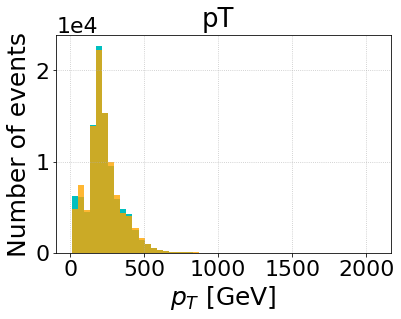

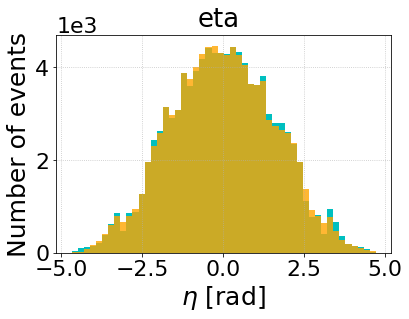

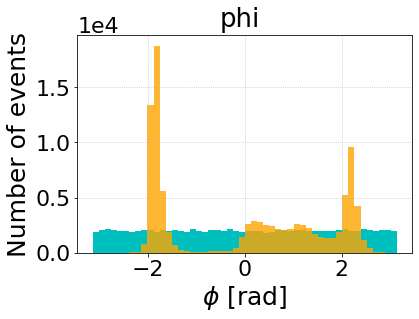

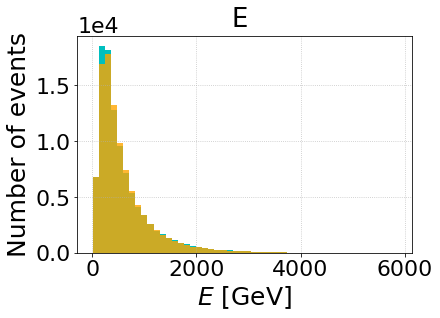

In [13]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()

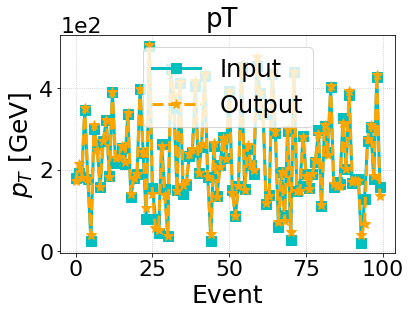

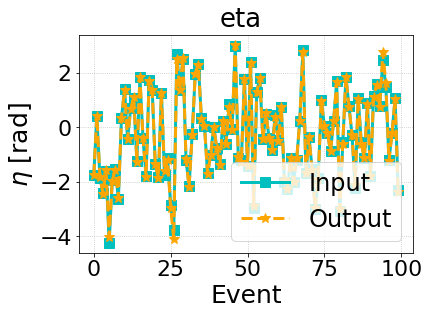

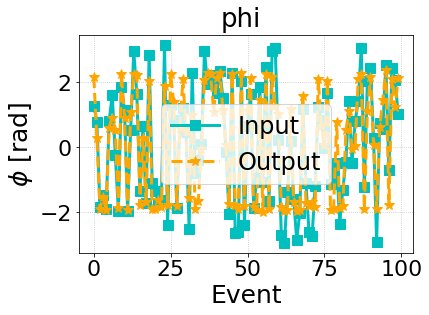

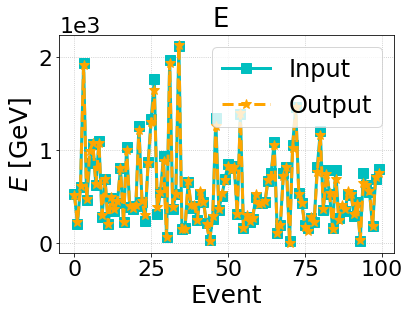

In [14]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()